In [1]:
from tsai.models import InceptionTime, TST, ResNet
# from tsai.data.core import get_UCR_data
# from tsai.learner import TSClassifier
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
''''DUMMY DATA'''
# import numpy as np
# import torch
# from tsai.models.ResNet import ResNet
# from fastai.learner import Learner
# from fastai.data.core import DataLoaders
# from fastai.metrics import accuracy

# # Create dummy data
# # Class 0: sine waves, Class 1: square waves
# n_samples = 200
# seq_len = 100
# n_channels = 1

# X_class0 = np.array([np.sin(np.linspace(0, 8 * np.pi, seq_len)) + 0.1 * np.random.randn(seq_len) for _ in range(n_samples)])
# X_class1 = np.array([np.sign(np.sin(np.linspace(0, 8 * np.pi, seq_len))) + 0.1 * np.random.randn(seq_len) for _ in range(n_samples)])

# X = np.concatenate([X_class0, X_class1], axis=0)
# y = np.array([0] * n_samples + [1] * n_samples)

# # Add channel dimension: (n_samples, n_channels, seq_len)
# X = X[:, None, :]

# # Train/test split
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
# y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# # Create DataLoaders
# train_ds = list(zip(X_train_tensor, y_train_tensor))
# valid_ds = list(zip(X_valid_tensor, y_valid_tensor))

# dls = DataLoaders.from_dsets(
#     train_ds,
#     valid_ds,
#     bs=32,
#     shuffle=True,
#     num_workers=0  # avoid multiprocessing issues
# )

# # Instantiate the model
# model = ResNet(n_channels, 2)  # 2 classes

# # Automatically use CUDA if available, otherwise use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Create Learner
# learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)

# # Manually move the model to the device
# learn.model.to(device)

# # Move the DataLoaders to the correct device as well
# learn.dls.to(device)

# # Train
# learn.fit_one_cycle(5, 1e-3)


In [3]:
'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)
train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


684
174
{'record_name': 'Hopper-2023_03_06_19_35_18-0000010181-0000-chan0', 'signal': array([[30.26377405],
       [51.72742573],
       [38.71189734],
       ...,
       [-1.23572809],
       [ 2.92797998],
       [-4.08031036]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 2094
  Preterm (1): 6270

Test label distribution:
  Term (0): 600
  Preterm (1): 1614


In [5]:
# from tsai.models.ResNet import ResNet
# from fastai.metrics import accuracy
# from fastai.data.core import DataLoaders
# from fastai.learner import Learner
# import torch
# import os
# import numpy as np
# from collections import Counter
# from torch.utils.data import TensorDataset

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Wrap your DataLoaders
# dls = DataLoaders.from_dsets(train_dataset, test_dataset, bs=batch_size)

# # Define model
# model = ResNet(1, 2)

# # Create Learner (this handles device placement)
# learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)

# # Train the model
# learn.fit_one_cycle(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.538970,0.580655,0.722222,00:09
1,0.528796,0.551602,0.723577,00:09
2,0.517966,0.579801,0.724481,00:09
3,0.523626,0.564399,0.726739,00:09
4,0.535496,0.577778,0.707769,00:09
5,0.524818,0.768902,0.710930,00:09
6,0.513427,0.657536,0.698284,00:09
7,0.510326,0.597319,0.728997,00:09
8,0.508438,0.750921,0.720867,00:09
9,0.496940,0.528654,0.719512,00:09


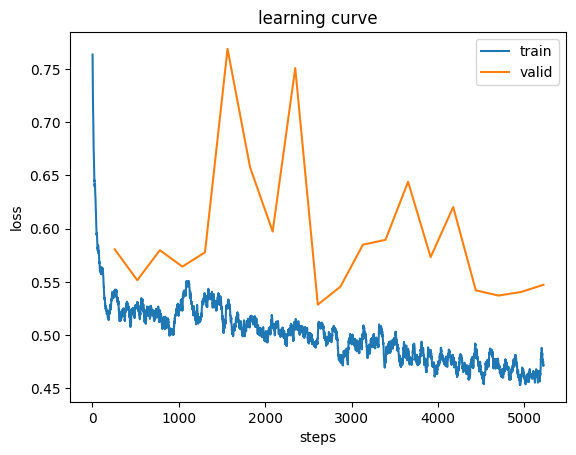

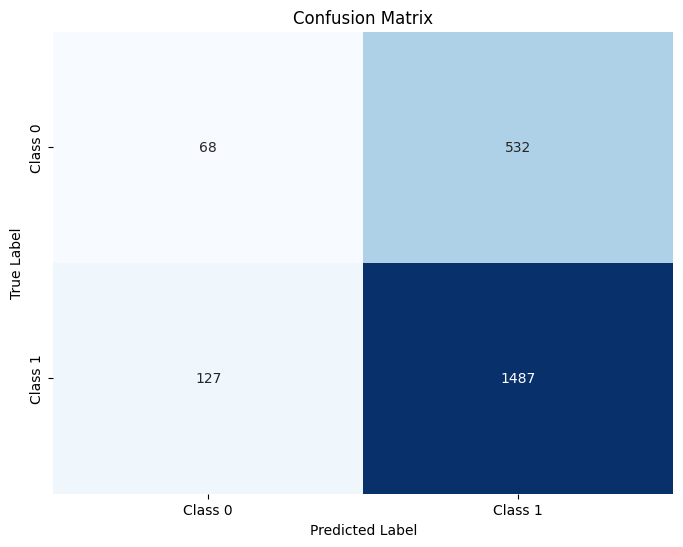

In [6]:
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)
# Define model
model = ResNet(1, 2)

# Create Learner
learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=accuracy)

# Optionally convert model to FP32 (if it was FP16 before), and ensure model is on correct device
learn.model.to(device)

learn.dls.to(device)
# Train
learn.fit_one_cycle(20, 1e-3)


learn.recorder.plot_loss()  # Plot loss curves (training and validation loss)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)

# Convert predictions to class labels (argmax for multi-class classification)
pred_labels = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

